Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data
#### To do: Take necessary actions to read the data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
## If you are using the data by mounting the google drive, use the following :
from google.colab import drive
drive.mount('/content/gdrive')

##Ref:https://towardsdatascience.com/downloading-datasets-into-google-drive-via-google-colab-bcb1b30b0166

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [10]:
!pwd

/content


In [11]:
# Defining the path for train and test images
## Todo: Update the paths of the train and test dataset
data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Test")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [27]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [26]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [14]:
## Write your train dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'training',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


In [15]:
## Write your validation dataset here
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split= 0.2,
    subset= 'validation',
    image_size=(img_height,img_width),
    batch_size = batch_size
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [16]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### Todo, create a code to visualize one instance of all the nine classes present in the dataset

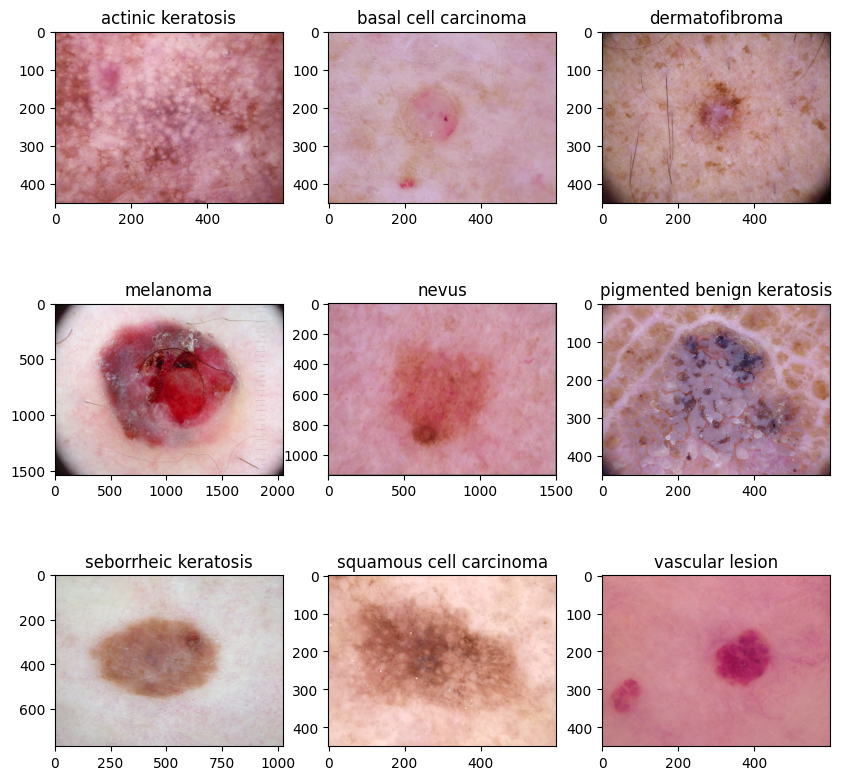

In [28]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3, 3, i + 1)
  image = plt.imread(str(list(data_dir_train.glob(class_names[i]+'/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)

### your code goes here, you can use training or validation data to visualize

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [18]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [32]:
### Your code goes here
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = tf.keras.Sequential([
    layers.Resizing(img_height, img_width),
    layers.Rescaling(1./255),
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training

In [33]:
### Todo, choose an appropirate optimiser and loss function
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [34]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resizing (Resizing)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ rescaling (Rescaling)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [35]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 328s 1s/step - accuracy: 0.1711 - loss: 2.1319 - val_accuracy: 0.2595 - val_loss: 2.0961
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.2857 - loss: 1.8937 - val_accuracy: 0.3915 - val_loss: 1.7122
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.3573 - loss: 1.7548 - val_accuracy: 0.3311 - val_loss: 1.8073
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 73ms/step - accuracy: 0.3586 - loss: 1.7444 - val_accuracy: 0.4049 - val_loss: 1.6652
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.4030 - loss: 1.6656 - val_accuracy: 0.3512 - val_loss: 1.7250
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 4s 72ms/step - accuracy: 0.3938 - loss: 1.6580 - val_accuracy: 0.4497 - val_loss: 1.5434
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 75ms/step - accuracy: 0.4398 - loss: 1.5637 - val_accuracy: 0.3848 - val_loss: 1.6991
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 5s 72ms/step - accuracy: 0.4233 - loss: 1.5688 - val_accuracy: 0.4855 - val_loss: 1.

### Visualizing training results

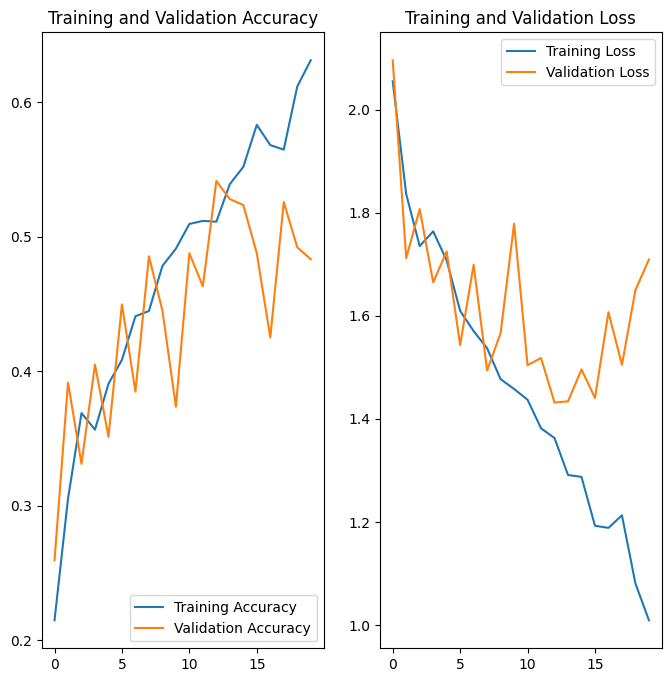

In [36]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit

### The model is overfitting, we can see difference between training and test validation


In [42]:
# Todo, after you have analysed the model fit history for presence of underfit or overfit, choose an appropriate data augumentation strategy.
data_augument = tf.keras.Sequential([
                             layers.RandomFlip(mode="horizontal_and_vertical",input_shape=(img_height,img_width,3)),
                             layers.RandomRotation(0.2, fill_mode='reflect'),
                             layers.RandomZoom(height_factor=(0.2, 0.3), width_factor=(0.2, 0.3), fill_mode='reflect')
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


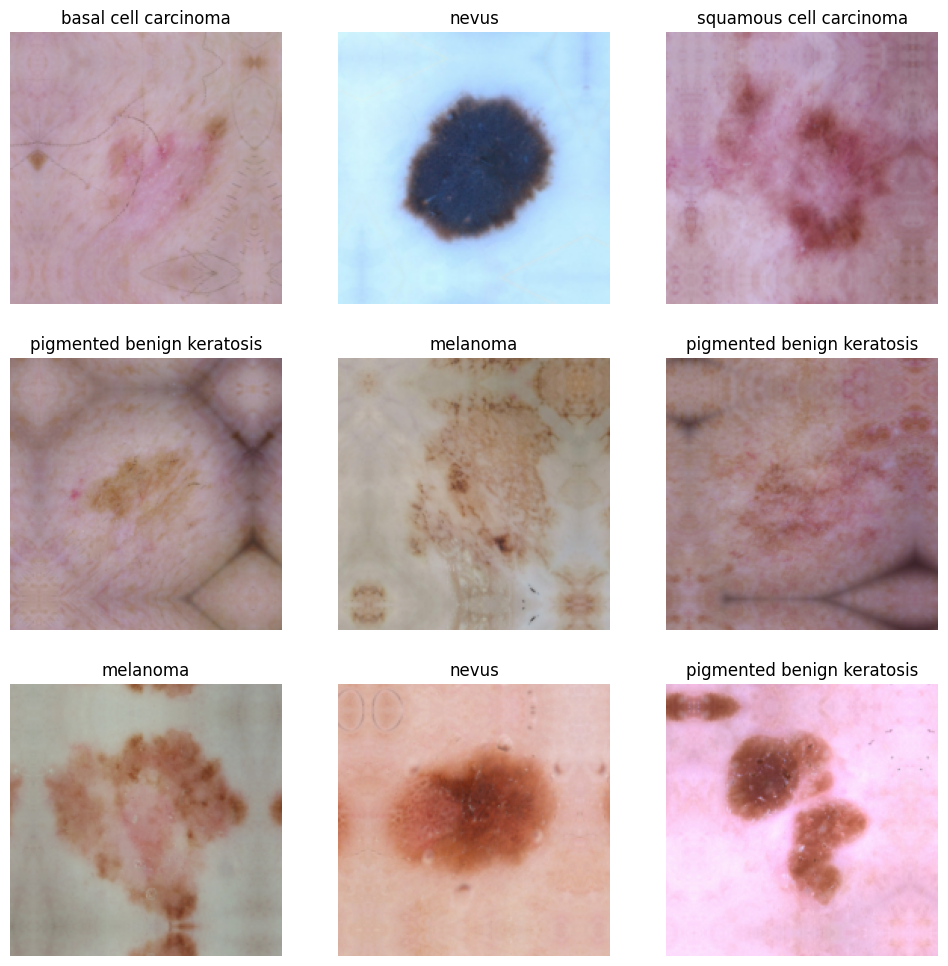

In [43]:
# Todo, visualize how your augmentation strategy works for one instance of training image.

plt.figure(figsize=(12, 12))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(data_augument(images)[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

### Todo:
### Create the model, compile and train the model


In [45]:
## You can use Dropout layer if there is an evidence of overfitting in your findings

from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = tf.keras.Sequential([data_augument,
    layers.Resizing(img_height, img_width),
    layers.Rescaling(1./255),
])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### Compiling the model

In [46]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

### Training the model

In [47]:
## Your code goes here, note: train your model for 20 epochs
epochs=20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


56/56 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - accuracy: 0.1762 - loss: 2.0968 - val_accuracy: 0.2058 - val_loss: 2.0138
Epoch 2/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.2498 - loss: 1.9767 - val_accuracy: 0.2640 - val_loss: 2.0263
Epoch 3/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 106ms/step - accuracy: 0.2579 - loss: 1.9520 - val_accuracy: 0.3199 - val_loss: 1.7985
Epoch 4/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 105ms/step - accuracy: 0.3492 - loss: 1.7455 - val_accuracy: 0.3781 - val_loss: 1.7194
Epoch 5/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 111ms/step - accuracy: 0.4051 - loss: 1.6623 - val_accuracy: 0.3826 - val_loss: 1.7192
Epoch 6/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - accuracy: 0.4357 - loss: 1.6114 - val_accuracy: 0.4787 - val_loss: 1.5685
Epoch 7/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 6s 107ms/step - accuracy: 0.4578 - loss: 1.5380 - val_accuracy: 0.4251 - val_loss: 1.5862
Epoch 8/20
56/56 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - accuracy: 0.4398 - loss: 1.5503 - val_accuracy: 0.4631 - v

### Visualizing the results

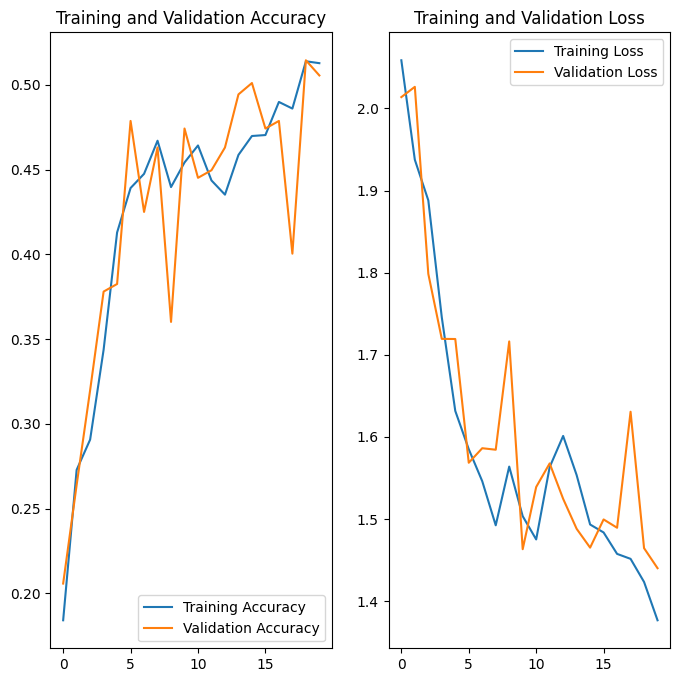

In [48]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()


#### Compared to previous model we can clearly see overfitting has reduced a lot.

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [49]:
##
path_list=[]
lesion_list=[]
for i in class_names:

    for j in data_dir_train.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
original_df

,Path,Label
0,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
1,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
2,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
3,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
4,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
...,...,...
2234,/content/gdrive/MyDrive/Train/vascular lesion/...,vascular lesion
2235,/content/gdrive/MyDrive/Train/vascular lesion/...,vascular lesion
2236,/content/gdrive/MyDrive/Train/vascular lesion/...,vascular lesion
2237,/content/gdrive/MyDrive/Train/vascular lesion/...,vascular lesion


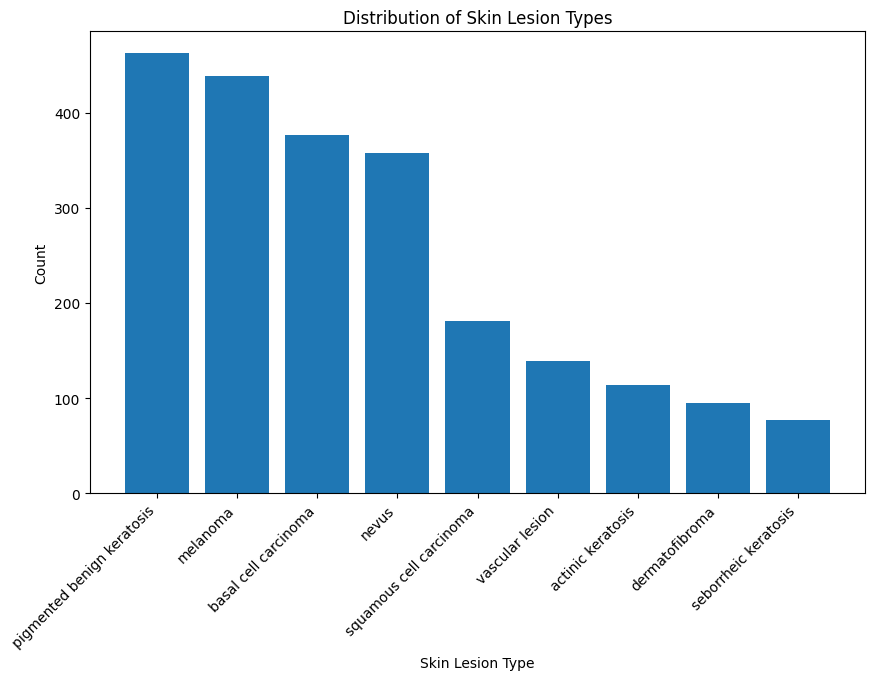

In [50]:
# @title Distribution of Skin Lesion Types

import matplotlib.pyplot as plt

label_counts = original_df['Label'].value_counts()
plt.figure(figsize=(10, 6))
plt.bar(label_counts.index, label_counts.values)
plt.xlabel('Skin Lesion Type')
plt.ylabel('Count')
plt.title('Distribution of Skin Lesion Types')
_ = plt.xticks(rotation=45, ha='right')


#### - Seborrheic has least number of samples
#### - Pigmented Bening Keratosis dominates the data


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [51]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [54]:
path_to_training_dataset="To do"
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline("/content/gdrive/MyDrive/Train")
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500)

Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B6400502FB0>: 100%|██████████| 500/500 [00:45<00:00, 10.90 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B63A337FD00>: 100%|██████████| 500/500 [00:42<00:00, 11.71 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B641FC76110>: 100%|██████████| 500/500 [00:40<00:00, 12.46 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x7B641C141420>: 100%|██████████| 500/500 [00:36<00:00, 13.68 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x768 at 0x7B641C3DC4C0>: 100%|██████████| 500/500 [00:43<00:00, 11.39 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B641F92FAF0>: 100%|██████████| 500/500 [00:41<00:00, 12.09 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x7B641FCF9E70>: 100%|██████████| 500/500 [00:43<00:00, 11.44 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B64000EDF30>: 100%|██████████| 500/500 [00:41<00:00, 12.00 Samples/s]


Initialised with 2239 image(s) found.
Output directory set to /content/gdrive/MyDrive/Train/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7B641C3B5450>: 100%|██████████| 500/500 [00:41<00:00, 11.96 Samples/s]


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [64]:
data_dir_train1 = pathlib.Path("/content/gdrive/MyDrive/Train/output")
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [67]:
for i in class_names:

    for j in data_dir_train1.glob(i+'/*.jpg'):
        path_list.append(str(j))
        lesion_list.append(i)
dataframe_dict_original = dict(zip(path_list, lesion_list))
new_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])
new_df

,Path,Label
0,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
1,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
2,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
3,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
4,/content/gdrive/MyDrive/Train/actinic keratosi...,actinic keratosis
...,...,...
6734,/content/gdrive/MyDrive/Train/output/vascular ...,vascular lesion
6735,/content/gdrive/MyDrive/Train/output/vascular ...,vascular lesion
6736,/content/gdrive/MyDrive/Train/output/vascular ...,vascular lesion
6737,/content/gdrive/MyDrive/Train/output/vascular ...,vascular lesion


So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [68]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [72]:
import pathlib
data_dir_train1=pathlib.Path("/content/gdrive/MyDrive/Train/output")
data_dir_train1
image_count_train1 = len(list(data_dir_train1.glob('*/*.jpg')))
print(image_count_train1)

import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train1,
  seed=123,
  validation_split = 0.2,
  subset = "training",
  image_size=(img_height, img_width),
  batch_size=batch_size)

4500
Found 4500 files belonging to 9 classes.
Using 3600 files for training.


#### **Todo:** Create a validation dataset

In [73]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 10 classes.
Using 1347 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [74]:
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D
num_classes = 9
model = tf.keras.Sequential([
                    layers.Rescaling(1./255, input_shape=(img_height, img_width,3))

])
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu', input_shape = (180, 180, 32)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters = 64, kernel_size = (5,5),padding = 'Same',
                 activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))


model.add(Flatten())
model.add(Dense(num_classes, activation = "softmax"))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


#### **Todo:** Compile your model (Choose optimizer and loss function appropriately)

In [75]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

#### **Todo:**  Train your model

In [76]:
epochs =50
## Your code goes here, use 50 epochs.
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:609: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


113/113 ━━━━━━━━━━━━━━━━━━━━ 45s 337ms/step - accuracy: 0.2266 - loss: 2.0448 - val_accuracy: 0.1700 - val_loss: nan
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 65s 237ms/step - accuracy: 0.3406 - loss: 1.7930 - val_accuracy: 0.1344 - val_loss: nan
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 27s 237ms/step - accuracy: 0.4388 - loss: 1.5696 - val_accuracy: 0.2123 - val_loss: nan
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 44s 264ms/step - accuracy: 0.4891 - loss: 1.4733 - val_accuracy: 0.2851 - val_loss: nan
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 40s 258ms/step - accuracy: 0.5345 - loss: 1.3402 - val_accuracy: 0.2539 - val_loss: nan
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step - accuracy: 0.5592 - loss: 1.2682 - val_accuracy: 0.2220 - val_loss: nan
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 41s 262ms/step - accuracy: 0.5990 - loss: 1.1947 - val_accuracy: 0.2940 - val_loss: nan
Epoch 8/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 39s 245ms/step - accuracy: 0.6202 - loss: 1.0648 - val_accuracy: 0.2502 - v

#### **Todo:**  Visualize the model results

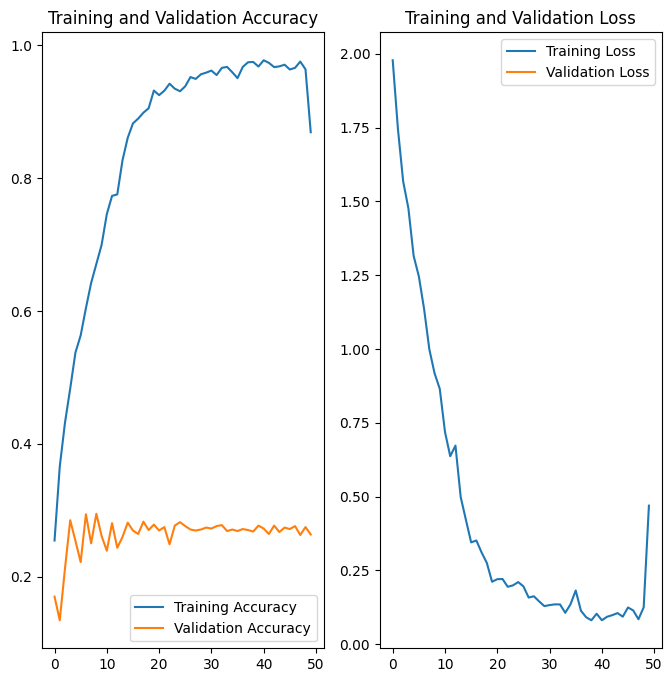

In [77]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### After Augmnetor the model shows overfitting. Need to have different model.

